**Notebook credit**: based on the F. Chollet's original notebook [here](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter04_getting-started-with-neural-networks.ipynb).

## IMDB, Classifying movie reviews: A binary classification example
binary classification 是最常见的 ML 问题之一.

我们将 classify IMDB movie reviews as positive or negative, based on the text content of the reviews.

## The IMDB dataset 的介绍

- this dataset has 50,000 highly polarized reviews from the Internet Movie Database
- is split into 25,000 reviews for training and 25,000 reviews for testing
- each set consisting of 50% negative and 50% positive reviews.
- like MNIST, the IMDB dataset comes packaged with Keras
- it's been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary
- this enables us to focus on model building, training, and evaluation
- later in the course, you’ll learn how to process raw text input from scratch.

**Loading the IMDB dataset**

In [1]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

17464789/17464789 [==============================] - 0s 0us/step


- `num_words=10000` means you'll only keep the top 10,000 most frequently occurring words in the training data
- discarding rare words allows us to work with vectors of manageable size
- if we didnt set this limit, we'd be working with 88,585 unique words
- rare words only occur in a few examples, and thus can't be meaningfully used for classification

**Training and test data format**

- variables `train_data` and `test_data` are lists of reviews
- each review is a list of word indices (encoding a sequence of words)
- `train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive

In [3]:
print(f"first training example has {len(train_data[0])} integer-encoded words")
print(f"in the first example, the first ten feature values are: {train_data[0][:10]}")

first training example has 218 integer-encoded words
in the first example, the first ten feature values are: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]


In [4]:
train_labels[0] # first review has label 1, i.e., it is positive

1

In [5]:
max([max(sequence) for sequence in train_data]) # check that word encoding integers are less than 10,000

9999

### data form: 每个 data point 是一个被 encode 为 integer 的 word list.

In [9]:
print(train_data[1:10])

[list([1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 8163, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 6853, 5, 163, 11, 3215, 2, 4, 1153, 9, 194, 775, 7, 8255, 2, 349, 2637, 148, 605, 2, 8003, 15, 123, 125, 68, 2, 6853, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 2, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 8255, 5, 2, 656, 245, 2350, 5, 4, 9837, 131, 152, 491, 18, 2, 32, 7464, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95])
 list([1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5974, 54, 61, 369, 13, 71, 149, 14, 22, 112, 4, 2401, 311, 12, 16, 3711, 33, 75, 43, 1829, 296, 4, 86, 320, 35

### **Decoding reviews back to text**

In [10]:
word_index = imdb.get_word_index()
list(word_index.items())[:10]

[('fawn', 34701),
 ('tsukino', 52006),
 ('nunnery', 52007),
 ('sonja', 16816),
 ('vani', 63951),
 ('woods', 1408),
 ('spiders', 16115),
 ('hanging', 2345),
 ('woody', 2289),
 ('trawling', 52008)]

In [11]:
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
list(reverse_word_index.items())[:10]

[(34701, 'fawn'),
 (52006, 'tsukino'),
 (52007, 'nunnery'),
 (16816, 'sonja'),
 (63951, 'vani'),
 (1408, 'woods'),
 (16115, 'spiders'),
 (2345, 'hanging'),
 (2289, 'woody'),
 (52008, 'trawling')]

In [12]:
 # offset of 3 needed because 0, 1, and 2 are reserved indices for "padding," "start of sequence," and "unknown."
decoded_review = [reverse_word_index.get(i - 3, "?") for i in train_data[0]]

print(train_data[0][:10])
print(" ".join(decoded_review[:10]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
? this film was just brilliant casting location scenery story


## Preparing the data: 数据预处理

### multi-hot encode: 把这些长度不同的 vectors 转化为长度相同的 (0,1) vector
- 我们无法直接把这些 lists of integers 放进 NN, 因为它们长度不同(不是同大小的 tensor). 因而我们需要把这些 lists 转化成大小相同的 tensors
- 有两个方法:
  1. **Pad(填充)** 这些 lists, 使得它们长度相同, 从而转化为 tensor of shape `(samples, max_length)`; 然后 start your model with a layer capable of handling such integer tensors (the `Embedding` layer). 这一方法我们会在之后的 CNN module 中 cover
  2. **Multi-hot encode**: 把这些 lists 全部变成 vectors of 0s and 1s, 长度约为词汇量的数量(大概估计一下, 不需要所有词汇), 而 0/1表示这个 list 中有没有这个词汇. 比如: 如果一个 list 是`[8, 5]`, 那么它被变为一个 10,000-dimensional 的 vector, 其中所有 entry 的值都是 0, 除了 index 为 8 和 5 的 entry 值为 1s. Then you could use a `Dense` layer, capable of handling floating-point vector data, as the first layer in your model.


#### 如何写一个 multi-hot encoding

In [13]:
len(train_data)

25000

In [15]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) # initialize results to an np.array with appropriate size
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1. # if word with index j found in sequence then set jth entry to 1 in multi-hot encoding
    return results
x_train = vectorize_sequences(train_data) # convert training data
x_test = vectorize_sequences(test_data)   # convert test data

In [16]:
x_train.shape

(25000, 10000)

In [17]:
x_test.shape

(25000, 10000)

In [18]:
example = np.array(train_data[0]) # list to np.array
np.unique(example[example < 10]) # which words with index < 10 occur in this example?


array([1, 2, 4, 5, 6, 7, 8, 9])

In [19]:
x_train[0][:10] # the words that occur determine where we place ones in the multi-hot encoding

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 1.])

In [20]:
y_train = np.array(train_labels).astype("float32")
y_test = np.array(test_labels).astype("float32")

## Building model

- we will use a plain stack of densely connected (`Dense`) layers with `relu` activations
- two key architecture decisions to be made:
  - how many layers to use
  - how many units to choose for each layer
  
Later you'll learn formal principles to guide you in making these choices. For the time being, you'll have to trust the following architecture choices:
- two intermediate layers with 16 units each
- a third layer that will output the scalar prediction

This is what the model looks like.

<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/IMDB_3_layers.png" alt="picture" height="300">

And note the similarity to the MNIST example you saw previously.

**Model definition**

- first argument being passed to each `Dense` layer is the number of units in the layer
- that's the dimensionality of representation space of the layer
- such a `Dense` layer with a `relu` activation implements the following chain of tensor operations:
```
output = relu(dot(input, W) + b)
```
- 16 units means the weight matrix `W` will have shape `(input_dimension, 16)`
- the dot (matrix) product with `W` will project the input data onto a 16-dimensional representation space
- Then the layer adds the bias vector `b` and applies the `relu` operation
- dimensionality of representation = "how much freedom you're allowing the model to have when learning internal representations"
- more units (a higher-dimensional representation space) means:
  - your model can learn more-complex representations
  - but it makes the model more computationally expensive and may lead to learning unwanted patterns (which can lead to overfitting)


### model 架构
我们采用两层 relu 权重 + 最后一层 sigmoid 二分类.


In [21]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

- intermediate layers use `relu` as their activation function
- the final layer uses a `sigmoid` activation so as to output a probability (a score between 0 and 1 indicating how likely the review is to be positive)
- `relu` (rectified linear unit) is a function meant to zero out negative values (see figure 4.2)
- `sigmoid` "squashes" arbitrary values into the `[0, 1]` interval (see figure 4.3), outputting a probability


<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/relu.png" height="300">

<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/sigmoid.png" height="300">

**Compiling the model**

In [22]:
model.compile(optimizer="rmsprop",         # good default choice for optimizer
              loss="binary_crossentropy",  # since our model outputs probabilities, cross entropy is a good choice
              metrics=["accuracy"])

### Validating your approach

- a deep learning model (or any ML model) should never be evaluated on its training data
- it’s standard practice to use a validation set to monitor the accuracy of the model during training
- we’ll create a validation set by setting apart 10,000 samples from the original training data

#### **Setting aside a validation set**

In [23]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

- we will now train the model for 15 epochs
- that's 15 iterations over all samples in the training data
- we will use mini-batches of 512 samples
- we will monitor loss and accuracy on the 10,000 samples that we set apart
- we do so by passing the validation data as the `validation_data` argument

**Training your model**

In [24]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=15,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/15
30/30 [==============================] - 4s 105ms/step - loss: 0.5669 - accuracy: 0.7649 - val_loss: 0.4496 - val_accuracy: 0.8502
Epoch 2/15
30/30 [==============================] - 1s 50ms/step - loss: 0.3698 - accuracy: 0.8805 - val_loss: 0.3400 - val_accuracy: 0.8795
Epoch 3/15
30/30 [==============================] - 1s 46ms/step - loss: 0.2785 - accuracy: 0.9078 - val_loss: 0.3020 - val_accuracy: 0.8836
Epoch 4/15
30/30 [==============================] - 2s 54ms/step - loss: 0.2270 - accuracy: 0.9239 - val_loss: 0.2802 - val_accuracy: 0.8898
Epoch 5/15
30/30 [==============================] - 2s 61ms/step - loss: 0.1888 - accuracy: 0.9381 - val_loss: 0.2770 - val_accuracy: 0.8868
Epoch 6/15
30/30 [==============================] - 2s 65ms/step - loss: 0.1625 - accuracy: 0.9461 - val_loss: 0.2877 - val_accuracy: 0.8854
Epoch 7/15
30/30 [==============================] - 1s 47ms/step - loss: 0.1397 - accuracy: 0.9558 - val_loss: 0.2853 - val_accuracy: 0.8870
Epoch 8/15
3

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                160016    
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160305 (626.19 KB)
Trainable params: 160305 (626.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- call to `model.fit()` returns a `History` object
- this object has a member `history`
- `history` is a dictionary containing data about everything that happened during training

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

The dictionary contains four entries: one per metric that was being monitored during training and during validation

#### **Plotting the training and validation loss**

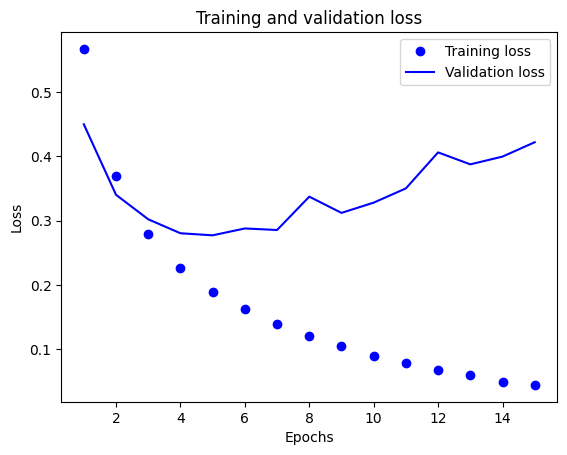

In [28]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### **Plotting the training and validation accuracy**

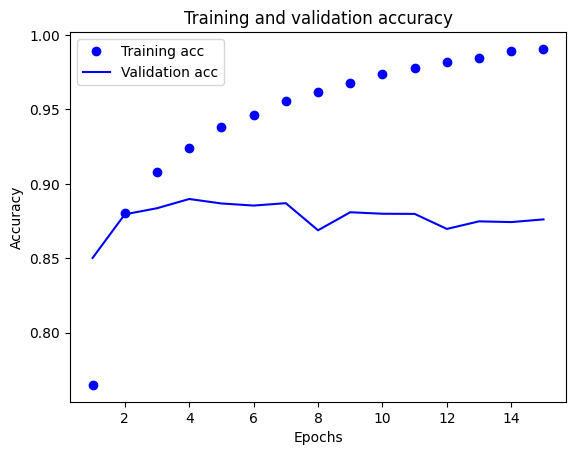

In [29]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

- training loss decreases with every epoch
- training accuracy increases with every epoch
- we're running gradient-descent optimization—the quantity we're trying to minimize should be less with every iteration
- but that isn't the case for the validation loss/accuracy: they seem to peak at the fourth epoch
- what we're seeing is *overfitting*: after the fourth epoch, we're overoptimizing on the training data
- we end up learning representations that are specific to the training data and don't generalize to data outside of the training set
- we could stop training after four epochs (early stopping)
- we will later see a range of techniques to mitigate overfitting

Let’s train a new model from scratch for four epochs and then evaluate it on the test data.


**Retraining a model from scratch**

In [30]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
print("Now evaluating the model on test set...")
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 2s 32ms/step - loss: 0.4669 - accuracy: 0.8159
Epoch 2/4
49/49 [==============================] - 2s 38ms/step - loss: 0.2744 - accuracy: 0.9010
Epoch 3/4
49/49 [==============================] - 2s 45ms/step - loss: 0.2162 - accuracy: 0.9221
Epoch 4/4
49/49 [==============================] - 2s 32ms/step - loss: 0.1833 - accuracy: 0.9342
Now evaluating the model on test set...
782/782 [==============================] - 2s 3ms/step - loss: 0.2903 - accuracy: 0.8843


In [31]:
results # gives us the loss and accuracy on the test set

[0.29025453329086304, 0.8842800259590149]

### Using a trained model to generate predictions on new data

In [32]:
predictions = model.predict(x_test)
predictions

782/782 [==============================] - 2s 3ms/step


array([[0.23204851],
       [0.99919087],
       [0.92084867],
       ...,
       [0.10426106],
       [0.10246832],
       [0.6336483 ]], dtype=float32)

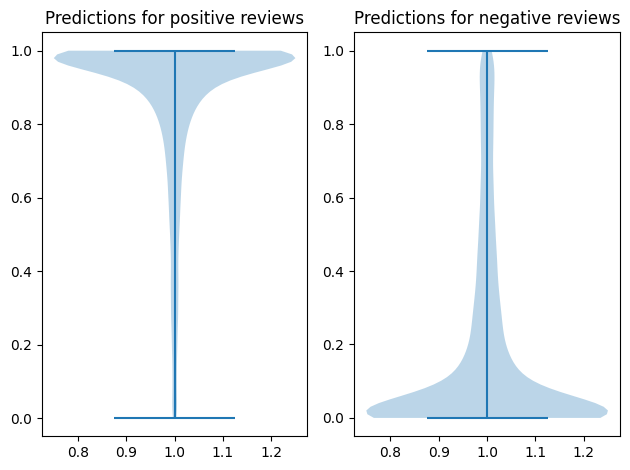

In [33]:
# for visualization purposes only
predictions_for_positives = predictions[y_test == 1]
predictions_for_negatives = predictions[y_test == 0]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Predictions for positive reviews')
ax1.violinplot(predictions_for_positives)
ax2.set_title('Predictions for negative reviews')
ax2.violinplot(predictions_for_negatives)
fig.tight_layout()
fig.show()

### Further experiments

Feel free to play with the code above by making one or more of the following changes:
- Try using one or three representation layers, and see how doing so affects validation and test accuracy.
- Try using layers with more units or fewer units: 32 units, 64 units, and so on.
- Try using the `mse` loss function instead of `binary_crossentropy`.
- Try using the `tanh` activation (an activation that was popular in the early days of neural networks) instead of `relu`.

### 打印出** first few mistakes**

In [34]:
mistakes = 1*(predictions > 0.5).squeeze() != y_test

In [35]:
for i in range(100): # look at incorrect predictions in the first 100 test set examples
  if mistakes[i]:
    decoded_review = [reverse_word_index.get(i - 3, "?") for i in test_data[i]]
    print(" ".join(decoded_review))
    print(f"model probability: {predictions[i][0]:.2f}, true label: {y_test[i]}")

? i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen with the dead kids are very cool but the alive people are absolute idiots i am a grown man pretty big and i can defend myself well however i would not do half the stuff the little girl does in this movie also the mother in this movie is reckless with her children to the point of neglect i wish i wasn't so angry about her and her actions because i would have otherwise enjoyed the flick what a number she was take my advise and fast forward through everything you see her do until the end also is anyone else getting sick of watching movies that are filmed so dark anymore one can hardly see what is being filmed as an audience we are ? involved with the actions on the screen so then why the hell can't we have night vision
model probability: 0.84, true label: 0.0
? hollywood had a long love affa